# Predict Future Sales Part 2: Model Training and Prediction


# Table of contents
* [1. Model Training](#sec1)
    * [1.1 Validation scheme](#sec1_1)
    * [1.2 LightGBM Regressor](#sec1_2)
    * [1.3 XGBoost Regressor](#sec1_3)
        * [1.3.1 Training XGBoost Regressor on GPU](#sec1_3_1)
    * [1.4 Linear regression](#sec1_4)
* [2. Ensembling Method](#sec2)
    * [2.1 Ensembling: LightGBM + Linear Regression](#sec2_1)    
* [3. Predictions](#sec3)    

In [101]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

import os
import pickle
from tqdm import tqdm #progress bar
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.linear_model import LinearRegression, Ridge, Lasso, Lars, ElasticNet
# from sklearn.externals import joblib
import joblib

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [2]:
#load processed data
df1 = pd.read_csv('./data_processed/data.csv', index_col=0)

In [103]:
data_folder = "./data/"
test = pd.read_csv(os.path.join(data_folder, "test.csv")).set_index('ID')

In [72]:
cat_features = ['shop_id_target_enc', 'item_id_target_enc', 
                'city_code_target_enc', 'item_category_id_x_target_enc', 
                'type_code_target_enc', 'subtype_code_target_enc']

# 1. Model Training  <a class="anchor" id="sec1"></a>


We will implement the following models:

- **Linear Regression**: preproccing is required and we will use `StandardScaler`;
- **XGBoost / LightBGM**: no preproccesing as decision tree are capable of handling features with different scales.

## 1.1 Validation scheme <a class="anchor" id="sec1_1"></a>

We choose **holdout** as out validation scheme: out training set runs from Jan.2013 to Sep.2015, validation set runs on Oct.2015. The test set runs on Nov.2015. 

In [4]:
all_data = copy.copy(df1)

X_train = all_data[all_data['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']

X_valid = all_data[all_data['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

X_test = all_data[all_data['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(6186922, 38)
(6186922,)
(238172, 38)
(238172,)
(214200, 38)


In [5]:
X_test.head()

,date_block_num,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,...,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
6425094,34,0.2585,0.5684,2.512,2.834,1.978,1.3,0.1901,0.2059,0.2451,...,0.000000,0.033116,0.0,0.0,0.0,0.000134,0.001819,0.000000,0.000000,0.000046
6425095,34,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0000,0.0000,0.0000,...,0.000395,0.034083,0.0,0.0,0.0,0.000464,0.000000,0.001306,0.001373,0.000597
6425096,34,0.2585,0.9546,1.860,3.572,1.613,0.0,0.1901,0.2059,0.2451,...,0.000000,0.032825,0.0,0.0,0.0,0.000014,0.015599,0.000000,0.000000,0.000000
6425097,34,0.2585,0.6360,1.116,1.548,0.000,0.0,0.1901,0.2059,0.2451,...,0.000000,0.033220,0.0,0.0,0.0,0.000251,0.012365,0.000187,0.000000,0.000177
6425098,34,0.0000,0.0000,0.000,0.000,0.000,0.0,0.0000,0.0000,0.0000,...,0.000000,0.032375,0.0,0.0,0.0,0.000000,0.019344,0.000000,0.000000,0.000000


## 1.2 LightGBM Regressor <a class="anchor" id="sec1_2"></a>

The correct metric to be used is **root mean squared error**

Our first model is regularized gradient boosting LightGBM.

In [6]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_valid, Y_valid)

params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

#next time, try to use GPU rather than CPU
model_lgbm = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid,
                      early_stopping_rounds=200, categorical_feature=cat_features, 
                       verbose_eval=50)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7654
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 38
[LightGBM] [Info] Start training from score 0.288849
[50]	valid_0's rmse: 0.99683
[100]	valid_0's rmse: 0.972024
[150]	valid_0's rmse: 0.968635
[200]	valid_0's rmse: 0.964639
[250]	valid_0's rmse: 0.964203
[300]	valid_0's rmse: 0.959738
[350]	valid_0's rmse: 0.957481
[400]	valid_0's rmse: 0.956257
[450]	valid_0's rmse: 0.954682
[500]	valid_0's rmse: 0.954533
[550]	valid_0's rmse: 0.957562
[600]	valid_0's rmse: 0.955514
[650]	valid_0's rmse: 0.954121
[700]	valid_0's rmse: 0.957515
[750]	valid_0's rmse: 0.956778
[800]	valid_0's rmse: 0.956383
[850]	valid_0's rmse: 0.956392
[900]	valid_0's rmse: 0.957082
[950]	valid_0's rmse: 0.954556
[1

In [7]:
print(np.sqrt(mean_squared_error(Y_valid, model_lgbm.predict(X_valid))))

0.9526578913079428


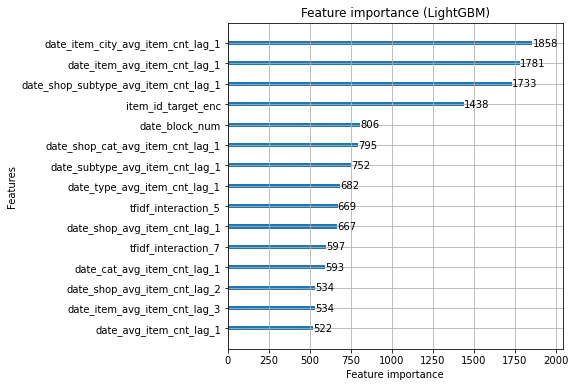

In [8]:
lgb.plot_importance(model_lgbm, max_num_features=15, figsize=(6,6), title='Feature importance (LightGBM)')
plt.show()

In [9]:
joblib.dump(model_lgbm, 'models/model1_lgbm.pkl');

In [10]:
model_lgbm = joblib.load('models/model1_lgbm.pkl') #how to save and check the parameters when load???

In [ ]:
# model_lgbm.save_model('models/model1_lgbm_txt.txt') #save
# model_lgbm_txt = lgb.Booster(model_file='models/model1_lgbm_txt.txt') #load

## 1.3 XGBoost Regressor <a class="anchor" id="sec1_3"></a>

Now we try XGBoost library.

In [13]:
model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                            colsample_bytree=0.8, subsample=0.8, eta=0.2, seed=42,
                            reg_alpha=0.2, reg_lambda=2.0)

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
             verbose=True, early_stopping_rounds=1000)  #start:10:29pm, end 1:23am

[0]	validation_0-rmse:1.08661
[1]	validation_0-rmse:1.04106
[2]	validation_0-rmse:1.00700
[3]	validation_0-rmse:0.98522
[4]	validation_0-rmse:0.96973
[5]	validation_0-rmse:0.96625
[6]	validation_0-rmse:0.96619
[7]	validation_0-rmse:0.96430
[8]	validation_0-rmse:0.95899
[9]	validation_0-rmse:0.95977
[10]	validation_0-rmse:0.96491
[11]	validation_0-rmse:0.96315
[12]	validation_0-rmse:0.96090
[13]	validation_0-rmse:0.96517
[14]	validation_0-rmse:0.96373
[15]	validation_0-rmse:0.96412
[16]	validation_0-rmse:0.96361
[17]	validation_0-rmse:0.96730
[18]	validation_0-rmse:0.96633
[19]	validation_0-rmse:0.96688
[20]	validation_0-rmse:0.97346
[21]	validation_0-rmse:0.97422
[22]	validation_0-rmse:0.97439
[23]	validation_0-rmse:0.97414
[24]	validation_0-rmse:0.97231
[25]	validation_0-rmse:0.97294
[26]	validation_0-rmse:0.97258
[27]	validation_0-rmse:0.97255
[28]	validation_0-rmse:0.97114
[29]	validation_0-rmse:0.97069
[30]	validation_0-rmse:0.97063
[31]	validation_0-rmse:0.97169
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.2, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000003,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.2, reg_lambda=2.0, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [15]:
print(np.sqrt(mean_squared_error(Y_valid, model_xgb.predict(X_valid))))

0.9589862849643996


In [16]:
joblib.dump(model_xgb, 'models/model2_xgb.pkl');

In [17]:
model_xgb = joblib.load('models/model2_xgb.pkl')

In [18]:
print(model_xgb.best_iteration)

8


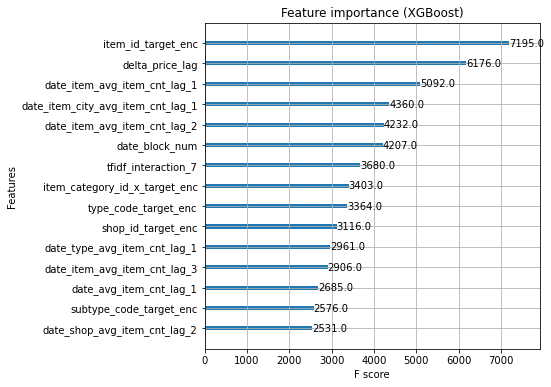

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model_xgb, max_num_features=15, title='Feature importance (XGBoost)', ax=ax)
plt.show()

### 1.3.1 Training XGBoost Regressor on GPU <a class="anchor" id="sec1_3_1"></a>

In [107]:
model_xgb = xgb.XGBRegressor(max_depth=8, n_estimators=1000, min_child_weight=300,
                            colsample_bytree=0.8, subsample=0.8, eta=0.2, seed=42,
                            reg_alpha=0.2, reg_lambda=2.0, tree_method='gpu_hist')

model_xgb.fit(X_train, Y_train, eval_metric='rmse', eval_set=[(X_valid, Y_valid)],
             verbose=True, early_stopping_rounds=1000)  #start:10:29pm, end 1:23am

[0]	validation_0-rmse:1.09784
[1]	validation_0-rmse:1.05084
[2]	validation_0-rmse:1.01831
[3]	validation_0-rmse:0.99852
[4]	validation_0-rmse:0.98759
[5]	validation_0-rmse:0.98004
[6]	validation_0-rmse:0.98165
[7]	validation_0-rmse:0.98494
[8]	validation_0-rmse:0.98522
[9]	validation_0-rmse:0.98720
[10]	validation_0-rmse:0.99005
[11]	validation_0-rmse:0.98801
[12]	validation_0-rmse:0.98630
[13]	validation_0-rmse:0.98710
[14]	validation_0-rmse:0.98984
[15]	validation_0-rmse:0.98794
[16]	validation_0-rmse:0.98700
[17]	validation_0-rmse:0.98645
[18]	validation_0-rmse:0.98770
[19]	validation_0-rmse:0.98833
[20]	validation_0-rmse:0.98834
[21]	validation_0-rmse:0.98967
[22]	validation_0-rmse:0.98967
[23]	validation_0-rmse:0.98990
[24]	validation_0-rmse:0.98659
[25]	validation_0-rmse:0.98862
[26]	validation_0-rmse:0.98868
[27]	validation_0-rmse:0.98878
[28]	validation_0-rmse:0.98803
[29]	validation_0-rmse:0.98574
[30]	validation_0-rmse:0.98569
[31]	validation_0-rmse:0.98715
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.2, gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.200000003,
             max_delta_step=0, max_depth=8, min_child_weight=300, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.2, reg_lambda=2.0, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

The XGBoost method ran on CPU cost 1h 23 min, ran on GPU only cost 57 seconds.

In [108]:
print(np.sqrt(mean_squared_error(Y_valid, model_xgb.predict(X_valid))))

0.9800386356080234


In [109]:
print(model_xgb.best_iteration)

5


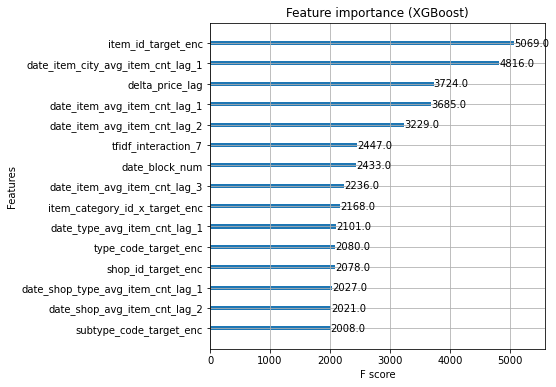

In [110]:
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(model_xgb, max_num_features=15, title='Feature importance (XGBoost)', ax=ax)
plt.show()

## 1.4 Linear regression <a class="anchor" id="sec1_4"></a>

We implement linear models `LinearRegression`, `Ridge`, `Lasso` as benchmarks.We need to implement *feature scaling* before fitting on the dataset.

**LinearRegression** model:

In [73]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)

In [74]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train_std, Y_train)

LinearRegression()

In [75]:
print(np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid_std))))

0.9900095967566781


In [76]:
joblib.dump(model_linreg, 'models/model3_linreg.pkl');

**Ridge** model:

In [77]:
model_ridge = Ridge(alpha=4.0, fit_intercept=True, max_iter=1000, solver='saga')
model_ridge.fit(X_train_std, Y_train)

Ridge(alpha=4.0, max_iter=1000, solver='saga')

In [78]:
print(np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid_std))))

0.9900082805056044


In [79]:
joblib.dump(model_ridge, 'models/model4_ridge.pkl');

**Lasso** model:

In [80]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train_std, Y_train)

Lasso(alpha=10.0)

In [81]:
print(np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid_std))))

1.1365538511881084


In [82]:
joblib.dump(model_lasso, 'models/model5_lasso.pkl');

# 2. Ensembling Method <a class="anchor" id="sec2"></a>

## 2.1 Ensembling: LightGBM + Linear Regression <a class="anchor" id="sec2_1"></a>

We will implement the KFold scheme time series implemented in the previous assignment.

  1. Split the train data into chunks of duration T, select first M chunks.
  2. Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until the end. After that, use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from M+1 and meta-features for test.
  3. Now we can use meta-features from first K chunks [M+1, M+2, ..., M+K] to fit level 2 models and validate them on chunk M+K+1.Essentially we are back to step 1 with lesser amount of chunks and meta-features instead of features.
  
We start with **1st generation features**:

In [85]:
model_lgbm = joblib.load('models/model1_lgbm.pkl')
model_linreg = joblib.load('models/model3_linreg.pkl')

In [86]:
Y_valid_lgbm = model_lgbm.predict(X_valid)
Y_valid_lreg = model_linreg.predict(X_valid_std)
X_valid_level2 = np.c_[Y_valid_lgbm, Y_valid_lreg]
X_valid_level2[:10,:]

array([[ 0.02086253, -0.06266107],
       [ 0.11747867, -0.04090796],
       [ 0.11699397,  0.11597089],
       [ 0.23048892,  0.40084696],
       [ 0.01993154,  0.00991157],
       [ 0.00094701, -0.08366587],
       [ 0.01659449, -0.09086691],
       [ 0.02121464, -0.10312856],
       [ 0.02121464, -0.10569445],
       [ 0.01867623, -0.09369751]])

Then **2nd generation feature**:

In [87]:
X_train = all_data[all_data['date_block_num']<=32].drop(['item_cnt_month'], axis=1)
Y_train = all_data[all_data['date_block_num']<=32]['item_cnt_month']
X_valid = all_data[all_data['date_block_num']==33].drop(['item_cnt_month'], axis=1)
Y_valid = all_data[all_data['date_block_num']==33]['item_cnt_month']

In [88]:
dates = all_data['date_block_num']
last_block = dates.max()
print('Test date_block_num is ',last_block)
dates_train = dates[dates < last_block]
dates_test = dates[dates == last_block]

Test date_block_num is  34


In [89]:
periods = np.arange(26, 33, 1)
periods

array([26, 27, 28, 29, 30, 31, 32])

In [90]:
dates_train_level2 = dates_train[dates_train.isin(periods)]
Y_train_level2 = Y_train[dates_train.isin(periods)]
X_train_level2 = np.zeros([Y_train_level2.shape[0], 2])

In [91]:
Y_train[dates_train.isin(periods)].shape == dates_train_level2.shape

True

In [ ]:
# cur_block_num = 26
# x = all_data[all_data['date_block_num'] < cur_block_num].drop(['item_cnt_month'], axis=1)
# y = all_data[all_data['date_block_num'] < cur_block_num]['item_cnt_month'].values
# x_test = all_data[all_data['date_block_num'] == cur_block_num].drop(['item_cnt_month'], axis=1)
# y = all_data[all_data['date_block_num'] == cur_block_num]['item_cnt_month'].values

In [92]:
#Now fill 'X_train_level2' with metafeatures

#params for lightGBM
params = {
    'boosting_type': 'dart',
    'metric': 'l2_root', # RMSE
    'verbose': 1,
    'seed': 0,
    'max_depth': 8,
    'learning_rate': 0.1,
    'reg_lambda': 2.0,
    'reg_alpha': 2.0,
    'subsample': 0.7,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'drop_rate': 0.2
}

for cur_block_num in periods:
    
    print('cur_block_num:', cur_block_num)
    
    # 1. split X_train into parts
    x = all_data[all_data['date_block_num'] < cur_block_num].drop(['item_cnt_month'], axis=1)
    y = all_data[all_data['date_block_num'] < cur_block_num]['item_cnt_month'].values
    x_test = all_data[all_data['date_block_num'] == cur_block_num].drop(['item_cnt_month'], axis=1)
    y_test = all_data[all_data['date_block_num'] == cur_block_num]['item_cnt_month'].values
    
    #2. Fit Linear regression
    print('Fitting Linear Regression:')
    lr = LinearRegression(fit_intercept=True, normalize=True)
    scaler = StandardScaler().fit(x)
    x_std = scaler.transform(x)
    x_test_std = scaler.transform(x_test)
    lr.fit(x_std, y)
    Y_test_1 = lr.predict(x_test_std)
    
    # 3. Fit LightGBM and prediction
    print('LightGBM:')
    n_trees = 500
    lgb_train = lgb.Dataset(x, y)
    lgb_valid = lgb.Dataset(x_test, y_test)
    model_lgbm = lgb.train(params, lgb_train, num_boost_round=n_trees, valid_sets=lgb_valid,
                          early_stopping_rounds=50, verbose_eval=50)
    Y_test_2 = model_lgbm.predict(x_test)
    
    # 4. Store predictions from 2 & 3 to 'X_train_level2'
    X_train_level2[dates_train_level2 == cur_block_num] = np.c_[Y_test_1, Y_test_2]
    clear_output()
    
print(X_train_level2.mean(axis=0))

[0.31901372 0.27264671]


In [95]:
np.savez('./data_processed/X_train_level2.npz',X_train_level2=X_train_level2)

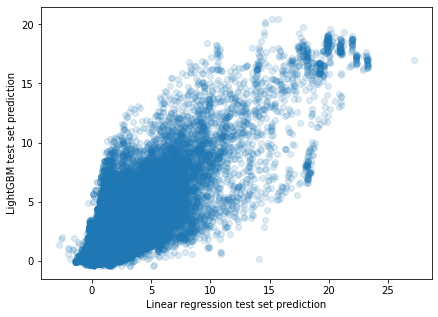

In [94]:
plt.figure(figsize=(7,5))
plt.scatter(X_train_level2[:,0], X_train_level2[:,1], marker='o', alpha=0.15)
plt.xlabel('Linear regression test set prediction')
plt.ylabel('LightGBM test set prediction')
plt.show()

Now we can do **stacking**.

In [96]:
Y_train_level2 = Y_train[dates_train.isin(periods)]
lr_stack = LinearRegression().fit(X_train_level2, Y_train_level2)

In [97]:
train_preds = lr_stack.predict(X_train_level2)
rmse_train = np.sqrt(mean_squared_error(Y_train_level2, train_preds))

valid_preds = lr_stack.predict(X_valid_level2)
rmse_valid = np.sqrt(mean_squared_error(Y_valid, valid_preds))

print('RMSE train: ', rmse_train)
print('RMSE test: ', rmse_valid)

RMSE train:  0.8091817048380416
RMSE test:  0.9788412024508074


# 3. Predictions <a class="anchor" id="sec3"></a>

In [98]:
X_test =  all_data[all_data['date_block_num']==34].drop(['item_cnt_month'], axis=1)

Y_test_lgbm = model_lgbm.predict(X_test).clip(0, 20)
Y_test_xgbm = model_xgb.predict(X_test).clip(0, 20)
Y_test_lreg = model_linreg.predict(X_test).clip(0, 20)
Y_test_ridge = model_ridge.predict(X_test).clip(0, 20)
Y_test_lasso = model_lasso.predict(X_test).clip(0, 20)

In [105]:
models = [Y_test_lgbm, Y_test_xgbm, Y_test_lreg, Y_test_ridge,
          Y_test_lasso]
names = ['LGBM', 'XGBM', 'LINREG', 'RIDGE', 'LASSO']

for model, name in zip(models, names):
    temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': model})
    temp.to_csv('submissions/submission_' + str(name) + '.csv', index=False)
    

Public leaderboard **Score**:

| Model | XGBoost | LightGBM | LinearRegression | Ridge | Lasso |
|-------|---------|----------|------------------|-------|-------|
| Score | 0.98971 | 0.98313  |      1.07821     |1.07822| 1.21744|

My official submission is LightGBM. Writing the data to `submission.cvs`.

In [106]:
temp = pd.DataFrame({'ID': test.index, 'item_cnt_month': Y_test_lgbm})
temp.to_csv('submissions/submission.csv', index=False)